# 📚 Image Captioning Challenge 📚

## 0-Imports



In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from tqdm import tqdm
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
import numpy as np

## 1- Data Reading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/caption_dataset/caption_dataset.zip" -d "/content/dataset/"

train_df = pd.read_csv("/content/dataset/train.csv")
test_df = pd.read_csv("/content/dataset/test.csv")
sample_df = pd.read_csv("/content/dataset/sample_submission.csv")

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
train_df.head()


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/dataset/train/train/550.jpg  
  inflating: /content/dataset/train/train/5500.jpg  
  inflating: /content/dataset/train/train/5501.jpg  
  inflating: /content/dataset/train/train/5502.jpg  
  inflating: /content/dataset/train/train/5503.jpg  
  inflating: /content/dataset/train/train/5504.jpg  
  inflating: /content/dataset/train/train/5505.jpg  
  inflating: /content/dataset/train/train/5506.jpg  
  inflating: /content/dataset/train/train/5507.jpg  
  inflating: /content/dataset/train/train/5508.jpg  
  inflating: /content/dataset/train/train/5509.jpg  
  inflating: /content/dataset/train/train/551.jpg  
  inflating: /content/dataset/train/train/5510.jpg  
  inflating: /content/dataset/train/train/5511.jpg  
  inflating: /content/dataset/train/train/5512.jpg  
  inflating: /content/dataset/train/train/5513.jpg  
  inflating: /content/dataset/train/train/5514.jpg  
  inflating: /content/dataset/train/train/5515.jpg  
 

,image_id,caption
0,0,The image features a comic-style panel depicti...
1,1,"Colorful postcard featuring ""Greetings from Ch..."
2,2,Two vending machines display a variety of drin...
3,3,A man speaks at the eGovernment Conference 201...
4,4,A close-up of several silver coins stacked tog...


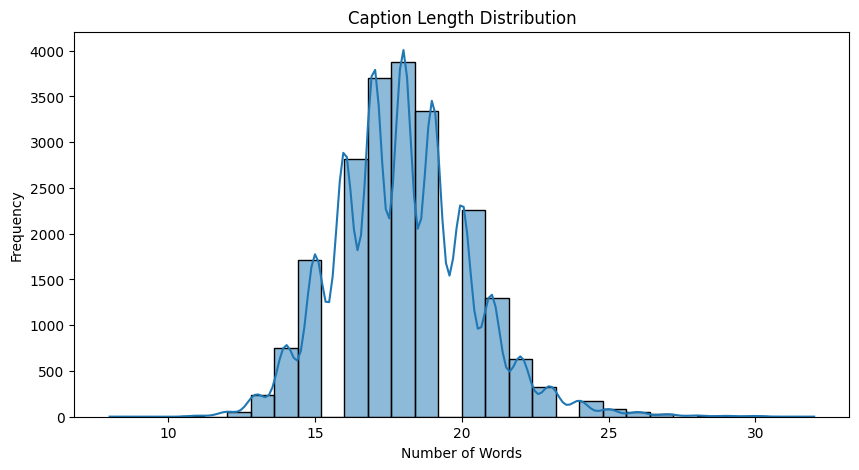

Unique captions: 21367
Average caption length: 17.971732110263492


In [2]:
train_df['caption_length'] = train_df['caption'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,5))
sns.histplot(train_df['caption_length'], bins=30, kde=True)
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()
print("Unique captions:", train_df['caption'].nunique())
print("Average caption length:", train_df['caption_length'].mean())


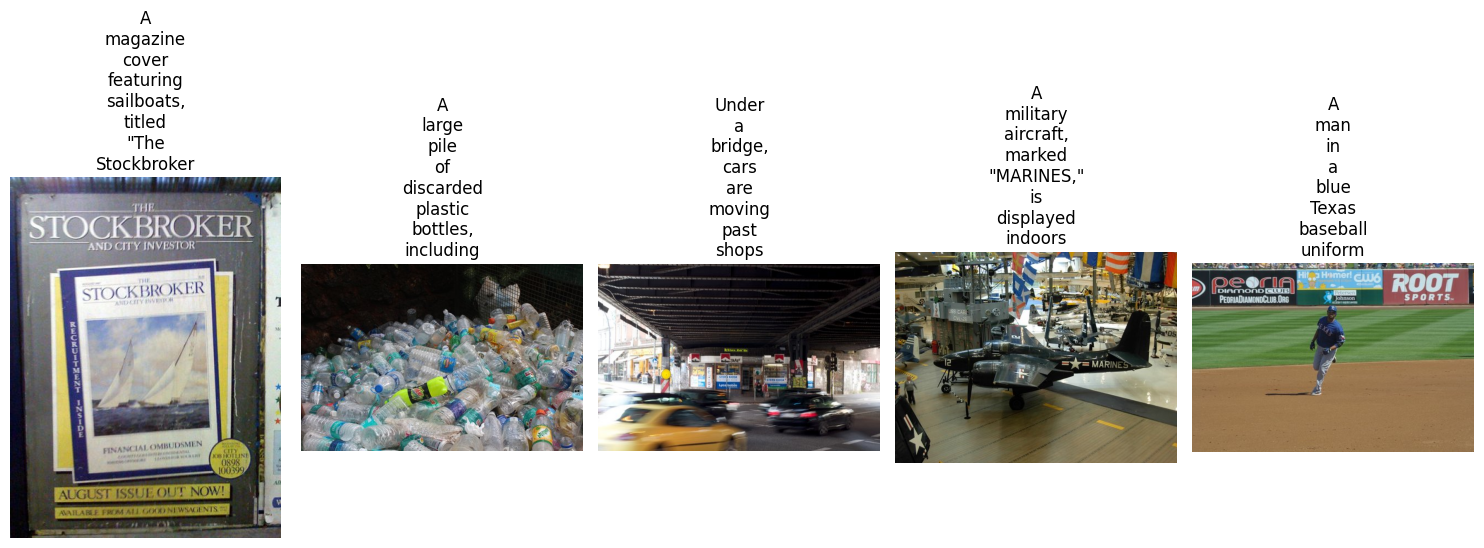

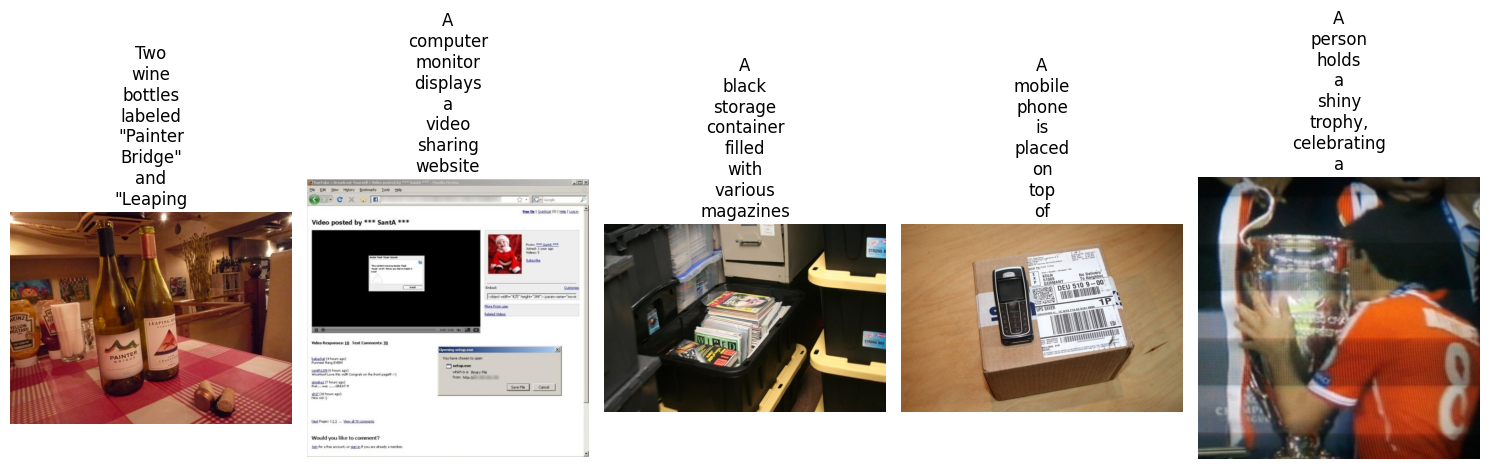

In [3]:
def show_random_examples(df, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        row = df.sample(1).iloc[0]
        img_filename = f"{row['image_id']}.jpg"
        img_path = f"/content/dataset/train/train/{img_filename}"
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        image = Image.open(img_path).convert("RGB")
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title("\n".join(row['caption'].split()[:8]))
    plt.tight_layout()
    plt.show()

show_random_examples(train_df, 5)
show_random_examples(train_df, 5)

In [ ]:
print("Unique captions:", train_df['caption'].nunique())
print("Average caption length:", train_df['caption_length'].mean())


Unique captions: 21367
Average caption length: 17.971732110263492


## 2- Data Preprocessing and Modelling

In [7]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
train_df['caption_proc'] = train_df['caption'].apply(lambda x: "<start> " + x.strip() + " <end>")

blip_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b",
                                                           device_map="auto", # distrubute CPU/GPU
                                                           torch_dtype=torch.float16)# float16 for Vram

device = "cuda" if torch.cuda.is_available() else "cpu"

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

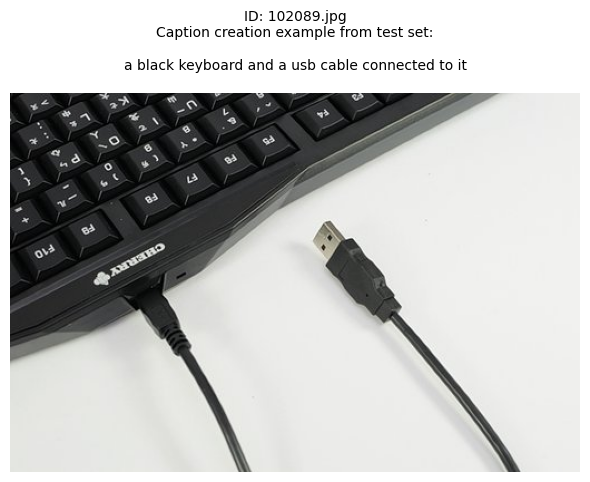

In [13]:
# Create example caption
sample_row = test_df.sample(1).iloc[0]
sample_img_id = str(sample_row['image_id'])
if not sample_img_id.endswith(".jpg"):
    sample_img_id += ".jpg"
img_path = f"/content/dataset/test/test/{sample_img_id}"

image = Image.open(img_path).convert("RGB")
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device, dtype=torch.float16) for k, v in inputs.items()}

with torch.no_grad():
    generated_ids = blip_model.generate(**inputs, max_new_tokens=30, do_sample=False)
caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.title(f"ID: {sample_img_id}\nCaption creation example from test set:\n\n{caption}", fontsize=10)
plt.tight_layout()
plt.show()

## 3-Creating Captions For submission.csv

In [17]:
submission = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = str(row["image_id"])
    if not img_id.endswith(".jpg"):
        img_id += ".jpg"
    img_path = f"/content/dataset/test/test/{img_id}"
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Image not found or corrupted: {img_path}")
        continue
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device, dtype=torch.float16) for k, v in inputs.items()}
    with torch.no_grad():
        generated_ids = blip_model.generate(**inputs, max_new_tokens=30, do_sample=False)
    caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    submission.append({"image_id": img_id, "caption": caption})

submission_df = pd.DataFrame(submission)
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

100%|██████████| 3771/3771 [24:07<00:00,  2.61it/s]


,image_id,caption
0,100000.jpg,a large billboard with a picture of a bird on ...
1,100001.jpg,a person holding a watch and a knife on a beach\n
2,100002.jpg,a shop with many signs and posters on the wall\n
3,100003.jpg,asus eee pc 1000e review\n
4,100004.jpg,a cross stitch picture with the words blasphim...


## 5- CALCULATE FGD SCORE

In [19]:
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer
gte_model = SentenceTransformer("thenlper/gte-small")

gt_df = pd.read_csv("/content/dataset/train.csv")
pred_df = pd.read_csv("submission.csv")
N = min(len(gt_df), len(pred_df))
gt_captions = gt_df["caption"].values[:N]
pred_captions = pred_df["caption"].values[:N]

gt_embed = gte_model.encode(list(gt_captions), batch_size=64, show_progress_bar=True)
pred_embed = gte_model.encode(list(pred_captions), batch_size=64, show_progress_bar=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

In [20]:
# Function from the datathon main page
def calculate_fgd(solution_embed: np.ndarray, submission_embed: np.ndarray) -> float:
    fgd_list = []
    for _idx, (sol_emb_sample, sub_emb_sample) in enumerate(zip(solution_embed, submission_embed)):
        sol_emb_sample_rshaped = sol_emb_sample.reshape((1,384))
        sub_emb_sample_rshaped = sub_emb_sample.reshape((1,384))
        e1 = np.concatenate([sol_emb_sample_rshaped, sol_emb_sample_rshaped])
        e2 = np.concatenate([sub_emb_sample_rshaped, sub_emb_sample_rshaped])
        mu1, sigma1 = e1.mean(axis=0), cov(e1, rowvar=False)
        mu2, sigma2 = e2.mean(axis=0), cov(e2, rowvar=False)
        ssdiff = np.sum((mu1 - mu2)**2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if iscomplexobj(covmean):
            covmean = covmean.real
        fgd = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        fgd_list.append(fgd)
    return float(np.mean(fgd_list))

In [21]:
fgd_score = calculate_fgd(gt_embed, pred_embed)
print(f"\nFinal FGD Score: {fgd_score:.4f}")



Final FGD Score: 0.4732
